In [2]:
import keras
import numpy as np
import pandas as pd
from keras import backend as K
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from sklearn.preprocessing import MinMaxScaler

Using TensorFlow backend.


In [3]:
base = pd.read_csv("dataset/petr4-treinamento.csv")
base = base.dropna() #Remove as linhas onde há colunas com valores faltantes

#Normalização de dimensionamento de recursos
base_treinamento = base.iloc[:, 1:2].values
normalizador = MinMaxScaler(feature_range=(0, 1))
base_treinamento_normalizada = normalizador.fit_transform(base_treinamento)

#Criando uma estrutura de dados com 90 timesteps e 1 output
x_treino = []
y_treino = []

for i in range(90, 1242):
	x_treino.append(base_treinamento_normalizada[i-90:i, 0])
	y_treino.append(base_treinamento_normalizada[i, 0])

x_treino, y_treino = np.array(x_treino), np.array(y_treino)

#Remodelando
x_treino = np.reshape(x_treino, (x_treino.shape[0], x_treino.shape[1], 1))

In [4]:
### Predição na base de teste ###

base_teste = pd.read_csv('dataset/petr4-teste.csv')
preco_real_teste = base_teste.iloc[:, 1:2].values

base_completa = pd.concat((base['Open'], base_teste['Open']), axis=0)

entradas = base_completa[len(base_completa) - len(base_teste)-90:].values
entradas = entradas.reshape(-1, 1)
entradas = normalizador.transform(entradas)

x_teste = []
for i in range(90, 112):
    x_teste.append(entradas[i-90:i, 0])

x_teste = np.array(x_teste)
x_teste = np.reshape(x_teste, (x_teste.shape[0], x_teste.shape[1], 1))

In [9]:
#RMSE
def root_mean_squared_error(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1))

#Criando modelo
model = Sequential()

#Adicionando camadas LSTM e alguma regularização de Dropout
model.add(LSTM(units=70,return_sequences=True,input_shape=(x_treino.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=60))
model.add(Dropout(0.2))
model.add(Dense(units=1, activation='linear'))

adam = keras.optimizers.Adam(learning_rate=0.01, beta_1=0.9, beta_2=0.999, amsgrad=False)
#sgd = keras.optimizers.SGD(momentum=0.1, lr=0.1, decay=0.1, nesterov=False)

#model.compile(optimizer = adam, loss='mean_squared_error', metrics=['mean_absolute_error']) #MAE
#model.compile(optimizer = adam, loss='mean_squared_error', metrics=['mean_squared_error']) #MSE
#model.compile(optimizer = adam, loss='mean_squared_error', metrics=['mean_absolute_percentage_error']) #MAPE
model.compile(optimizer = adam, loss='mean_squared_error', metrics=[root_mean_squared_error]) #RMSE

model.fit(x_treino, y_treino, epochs=200, batch_size=40)

preco_predito = model.predict(x_teste)
preco_predito = normalizador.inverse_transform(preco_predito)

#Evaluate the model
scores = model.evaluate(x_treino, y_treino)
print("%s: %.4f" % (model.metrics_names[1], scores[1]))

Epoch 1/200
1152/1152 [==============================] - 4s 3ms/step - loss: 0.0331 - root_mean_squared_error: 0.1245
Epoch 2/200
1152/1152 [==============================] - 3s 3ms/step - loss: 0.0033 - root_mean_squared_error: 0.0436
Epoch 3/200
1152/1152 [==============================] - 3s 3ms/step - loss: 0.0028 - root_mean_squared_error: 0.0402
Epoch 4/200
1152/1152 [==============================] - 3s 3ms/step - loss: 0.0030 - root_mean_squared_error: 0.0413
Epoch 5/200
1152/1152 [==============================] - 3s 3ms/step - loss: 0.0024 - root_mean_squared_error: 0.0367
Epoch 6/200
1152/1152 [==============================] - 3s 3ms/step - loss: 0.0022 - root_mean_squared_error: 0.0349
Epoch 7/200
1152/1152 [==============================] - 3s 3ms/step - loss: 0.0021 - root_mean_squared_error: 0.0352
Epoch 8/200
1152/1152 [==============================] - 3s 3ms/step - loss: 0.0023 - root_mean_squared_error: 0.0366
Epoch 9/200
1152/1152 [==============================] -

1152/1152 [==============================] - 3s 3ms/step - loss: 8.4544e-04 - root_mean_squared_error: 0.0217
Epoch 135/200
1152/1152 [==============================] - 3s 3ms/step - loss: 8.7840e-04 - root_mean_squared_error: 0.0219
Epoch 136/200
1152/1152 [==============================] - 3s 3ms/step - loss: 7.8499e-04 - root_mean_squared_error: 0.0204
Epoch 137/200
1152/1152 [==============================] - 3s 3ms/step - loss: 8.0979e-04 - root_mean_squared_error: 0.0209
Epoch 138/200
1152/1152 [==============================] - 3s 3ms/step - loss: 9.1923e-04 - root_mean_squared_error: 0.0224
Epoch 139/200
1152/1152 [==============================] - 3s 3ms/step - loss: 8.9836e-04 - root_mean_squared_error: 0.0222
Epoch 140/200
1152/1152 [==============================] - 3s 3ms/step - loss: 9.4385e-04 - root_mean_squared_error: 0.0227
Epoch 141/200
1152/1152 [==============================] - 3s 3ms/step - loss: 8.2876e-04 - root_mean_squared_error: 0.0215
Epoch 142/200
1152/115

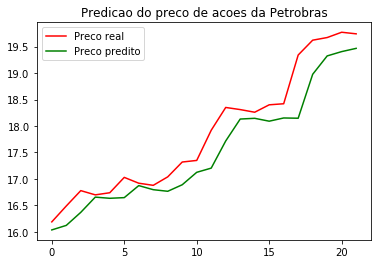

In [6]:
#Plotando resultados
plt.plot(preco_real_teste, color = 'red', label = 'Preco real')
plt.plot(preco_predito, color = 'green', label = 'Preco predito')
plt.title('Predicao do preco de acoes da Petrobras')
plt.legend()
plt.show()